In [1898]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import requests
import seaborn as sns

from dotenv import load_dotenv
from functools import reduce
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler, LabelEncoder, RobustScaler
from sklearn.svm import SVC, SVR
from xgboost import XGBClassifier, XGBRegressor, plot_importance

%matplotlib inline
plt.style.use("ggplot")
sns.set_context("talk")

In [792]:
load_dotenv("")
FREDkey = os.getenv("FREDkey")

In [985]:
varlist = ["WILL5000INDFC",
           "NIKKEI225",
           "CPIAUCSL",
           "CPIFABSL",
           "CPIHOSSL",
           "IC4WSA",
           "INDPRO",
           "IPMAN",
           "HOUST",
           "HSN1F",
           "RELACBW027SBOG",
           "MSPNHSUS",
           "USSTHPI",
           "AHETPI",
           "PCE",
           "PCEND",
           "DAUTOSAAR",
           "PI",
           "A229RX0",
           "DEXJPUS",
           "DTWEXM",
           "DGS30",
           "DGS10",
           "DGS2",
           "DGS5",
           "DTB3",
           "MORTGAGE30US",
           "AAA",
           "BAA",
           "BAMLCC0A0CMTRIV",
           "FEDFUNDS",
           "TB3SMFFM",
           "UMCSENT",  
           "CIVPART",
           "TCU",
           "UNRATE",
           "LNS14000002",
           "LNS15000000",
           "UEMPMEAN",
           "USCONS",
           "NFCI",
           "USRECDM",
           "GDPPOT",
           "GDPC1",
           "GOLDPMGBD228NLBM",
           "WTISPLC",
           "CMRMTSPL",
           "TERMCBAUTO48NS",
           "TERMCBPER24NS",
           "NONREVSL",
           "CEFDFSA066MSFRBPHI",
           "M1SL",
           "MABMM301USM189S",
           "TOTALSA",
           "INTDSRUSM193N",
           "PSAVERT",
           "TOTCI",
           "TOTLL",
           "TOTBKCR",
           "DPRIME",
           "MSACSR",
           "PPIACO",
           "PERMIT",
           "DSPIC96",
           "TLAACBW027SBOG",
           "M12MTVUSM227NFWA",
           "AWHMAN",
           "CCSA",
           "TCD",
           "CSCICP03USM665S"
          ]

In [986]:
datalist=[]
for var in varlist:
    resp = requests.get(
        "https://api.stlouisfed.org/fred/series/observations?series_id={}&api_key={}&file_type=json"
        .format(var, 
                FREDkey))
    df = pd.DataFrame(resp.json()['observations'])
    df.date = pd.to_datetime(df.date)
    df = df.loc[df.value!="."]
    df.value = df.value.astype(float)
    df.index = df.date
    df.drop(columns=["realtime_end", "realtime_start", "date"], axis=1, inplace=True)
    df.columns=[var]
    df= df.resample("1D").interpolate(method='linear')
    datalist.append(df)

WILL5000INDFC
NIKKEI225
CPIAUCSL
CPIFABSL
CPIHOSSL
IC4WSA
INDPRO
IPMAN
HOUST
HSN1F
RELACBW027SBOG
MSPNHSUS
USSTHPI
AHETPI
PCE
PCEND
DAUTOSAAR
PI
A229RX0
DEXJPUS
DTWEXM
DGS30
DGS10
DGS2
DGS5
DTB3
MORTGAGE30US
AAA
BAA
BAMLCC0A0CMTRIV
FEDFUNDS
TB3SMFFM
UMCSENT
CIVPART
TCU
UNRATE
LNS14000002
LNS15000000
UEMPMEAN
USCONS
NFCI
USRECDM
GDPPOT
GDPC1
GOLDPMGBD228NLBM
WTISPLC
CMRMTSPL
TERMCBAUTO48NS
TERMCBPER24NS
NONREVSL
CEFDFSA066MSFRBPHI
M1SL
MABMM301USM189S
TOTALSA
INTDSRUSM193N
PSAVERT
TOTCI
TOTLL
TOTBKCR
DPRIME
MSACSR
PPIACO
PERMIT
DSPIC96
TLAACBW027SBOG
M12MTVUSM227NFWA
AWHMAN
CCSA
TCD
CSCICP03USM665S


In [1385]:
df_merged = reduce(lambda left, right: pd.merge(left, right, on='date', how='outer'), datalist)

In [1386]:
df_merged.shape

(63858, 70)

In [1387]:
df_merged["2-10"] = df_merged.DGS10 - df_merged.DGS2
df_merged["10-30"] = df_merged.DGS30 - df_merged.DGS10
df_merged["positive_gap"] = df_merged.GDPC1.pct_change(365) - df_merged.GDPPOT.pct_change(365) > 0
df_merged["gap"] = df_merged.GDPC1.pct_change(365) - df_merged.GDPPOT.pct_change(365)
df_WILL5000_5d_vol = df_merged.WILL5000INDFC.pct_change(1).rolling(5).std()
df_WILL5000_30d_vol = df_merged.WILL5000INDFC.pct_change(1).rolling(30).std()

In [1388]:
df_WILL5000_5d_vol= df_WILL5000_5d_vol.loc[df_merged.DGS30>-10].resample("1W").mean()
df_WILL5000_30d_vol= df_WILL5000_30d_vol.loc[df_merged.DGS30>-10].resample("1W").mean()
df_merged = df_merged.loc[df_merged.DGS30>-10].resample("1W").mean()

In [1389]:
percent = ["WILL5000INDFC",
           "NIKKEI225",
           "CPIAUCSL", 
           "CPIFABSL",
           "CPIHOSSL",
           "IC4WSA",
           "INDPRO",
           "IPMAN",
           "HOUST",
           "HSN1F",
           "RELACBW027SBOG",
           "MSPNHSUS",
           "USSTHPI",
           "AHETPI",
           "PCE",
           "PCEND",
           "DAUTOSAAR",
           "A229RX0",
           "DEXJPUS",
           "DTWEXM",
           "GOLDPMGBD228NLBM",
           "WTISPLC",
           "BAMLCC0A0CMTRIV",
           "CMRMTSPL",
           "NONREVSL",
           "M1SL",
           "MABMM301USM189S",
           "TOTALSA",
           "TOTCI",
           "TOTLL",
           "TOTBKCR",
           "PPIACO",
           "PERMIT",
           "DSPIC96",
           "TLAACBW027SBOG",
           "M12MTVUSM227NFWA",
           "PI",
           "AWHMAN",
           "CCSA",
           "TCD",
           "UEMPMEAN",
           "LNS15000000",
           "USCONS"
          ]

In [1534]:
actual = ["DGS30",
          "DGS10",
          "DGS2",
          "DGS5",
          "DTB3",
          "MORTGAGE30US",
          "AAA",
          "BAA",
          "FEDFUNDS",
          "TB3SMFFM",
          "UMCSENT",  
          "CIVPART",
          "TCU",
          "UNRATE",
          "LNS14000002",
          "NFCI",
          "2-10",
          "10-30",
          "gap",
          "TERMCBAUTO48NS",
          "TERMCBPER24NS",
          "CEFDFSA066MSFRBPHI",
          "INTDSRUSM193N",
          "PSAVERT",
          "DPRIME",
          "MSACSR",
          "CSCICP03USM665S"
         ]

In [1535]:
def change(df, percent, actual, period):
    df_actual = df[actual].diff(period).fillna(method='ffill')

    df_percent = df[percent].pct_change(period).fillna(method='ffill')
    df_concat = pd.concat([df_actual, df_percent], axis=1)
    df_concat.columns = [str(col) + '_{}'.format(period) for col in df_concat.columns]
    return df_concat

In [1536]:
week = change(df_merged, percent, actual, 1)
week_week = week.diff(1).add_suffix("_1")
month = change(df_merged, percent, actual, 4)
month_month = month.diff(4).add_suffix("_4")
three_m = change(df_merged, percent, actual, 13)
three_three = three_m.diff(13).add_suffix("_13")
six_m = change(df_merged, percent, actual, 26)
six_six = six_m.diff(26).add_suffix("_26")
one_y = change(df_merged, percent, actual, 52)

In [1537]:
X = pd.concat([week, 
               week_week, 
               month, 
               month_month, 
               three_m, 
               three_three, 
               six_m, 
               six_six, 
               one_y,
               df_merged[actual].fillna(method="ffill"),
               df_merged[actual].fillna(method="ffill").shift(1),
               df_merged[actual].fillna(method="ffill").shift(4),
               df_merged[actual].fillna(method="ffill").shift(13),
               df_merged[actual].fillna(method="ffill").shift(26),
               df_merged[actual].fillna(method="ffill").shift(52),
               df_WILL5000_5d_vol,
               df_WILL5000_30d_vol
              ], axis=1)[52:]

In [1538]:
# X = pd.concat([week, 
#                week_week, 
#                month, 
#                month_month, 
#                three_m, 
#                three_three, 
#                six_m, 
#                six_six, 
#                one_y,
#               ], axis=1)[52:]

In [1539]:
y1w = df_merged.positive_gap.shift(-1)[X.index].fillna(method="ffill").apply(lambda x: 1 if x>0.5 else 0)
y1m = df_merged.positive_gap.shift(-4)[X.index].fillna(method="ffill").apply(lambda x: 1 if x>0.5 else 0)
y3m = df_merged.positive_gap.shift(-13)[X.index].fillna(method="ffill").apply(lambda x: 1 if x>0.5 else 0)
y6m = df_merged.positive_gap.shift(-26)[X.index].fillna(method="ffill").apply(lambda x: 1 if x>0.5 else 0)
y12m = df_merged.positive_gap.shift(-52)[X.index].fillna(method="ffill").apply(lambda x: 1 if x>0.5 else 0)

In [1540]:
# GDPC1y1w = df_merged.USREC.shift(-1)[X.index].fillna(method="ffill").apply(lambda x: 1 if x>0.5 else 0)
# y1m = df_merged.USREC.shift(-4)[X.index].fillna(method="ffill").apply(lambda x: 1 if x>0.5 else 0)
# y3m = df_merged.USREC.shift(-13)[X.index].fillna(method="ffill").apply(lambda x: 1 if x>0.5 else 0)
# y6m = df_merged.USREC.shift(-26)[X.index].fillna(method="ffill").apply(lambda x: 1 if x>0.5 else 0)
# y12m = df_merged.USREC.shift(-52)[X.index].fillna(method="ffill").apply(lambda x: 1 if x>0.5 else 0)

In [1541]:
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X))

In [1542]:
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

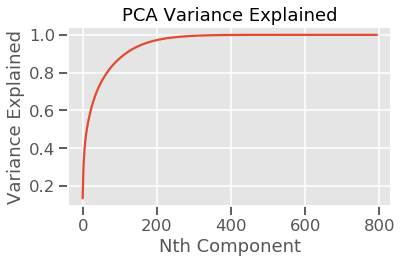

In [1543]:
plt.plot(pca.explained_variance_ratio_.cumsum())
plt.title("PCA Variance Explained")
plt.xlabel("Nth Component")
plt.ylabel("Variance Explained")
plt.tight_layout()
plt.savefig("../images/pca")

In [1721]:
n_pc = 150

In [1722]:
X_train = X_pca[:int(X_pca.shape[0]*0.7), :n_pc]
X_test = X_pca[int(X_pca.shape[0]*0.7):, :n_pc]

In [1723]:
X_train.shape

(1515, 150)

In [1724]:
y1w.shape

(2165,)

In [1725]:
y1w_train = y1w[:int(X_pca.shape[0]*0.7)]
y1w_test = y1w[int(X_pca.shape[0]*0.7):]

In [1548]:
clf = SVC(C=0.1, gamma=0.001, probability=True)
clf.fit(X_train, y1w_train)
confusion_matrix(clf.predict(X_test), y1w_test)

array([[126,  27],
       [ 98, 399]])

In [1549]:
clf.score(X_train, y1w_train)

0.8950495049504951

In [1550]:
clf.score(X_test, y1w_test)

0.8076923076923077

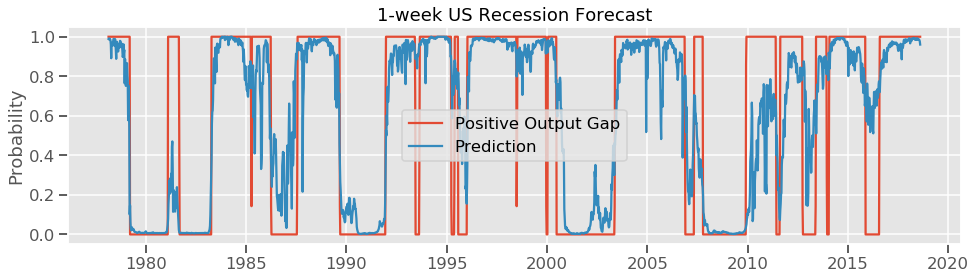

In [1553]:
pred = pd.DataFrame(clf.predict_proba(X_pca[:, :n_pc])[:, 1])
pred.set_index(X.index, inplace=True)
pred.columns = ["pred"]
fig = plt.figure(figsize=(16,4))
ax = plt.plot(pd.merge(df_merged.positive_gap[X_scaled.index], pred, on="date"))
plt.title("1-week US Recession Forecast")
plt.ylabel("Probability")
plt.legend(["Positive Output Gap", "Prediction"])
plt.savefig("../images/1w_gap_svc")
plt.show()

In [1554]:
y1m_train = y1m[:int(X_pca.shape[0]*0.7)]
y1m_test = y1m[int(X_pca.shape[0]*0.7):]

In [1558]:
clf = SVC(C=20, gamma=0.00001, probability=True)
clf.fit(X_train, y1m_train)
print(confusion_matrix(clf.predict(X_test), y1m_test))
print("train:", clf.score(X_train, y1m_train))
print("test", clf.score(X_test, y1m_test))

[[117  37]
 [107 389]]
train: 0.9465346534653465
test 0.7784615384615384


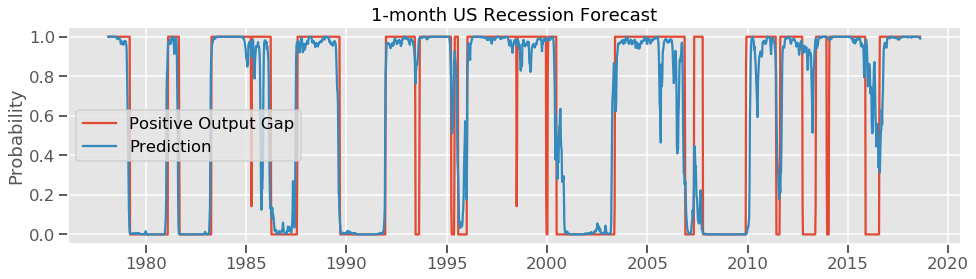

In [1560]:
pred = pd.DataFrame(clf.predict_proba(X_pca[:, :n_pc])[:, 1])
pred.set_index(X.index, inplace=True)
pred.columns = ["pred"]
fig = plt.figure(figsize=(16,4))
ax = plt.plot(pd.merge(df_merged.positive_gap[X_scaled.index], pred, on="date"))
plt.title("1-month US Recession Forecast")
plt.ylabel("Probability")
plt.legend(["Positive Output Gap", "Prediction"])
plt.savefig("../images/1m_gap_svc")
plt.show()

In [1561]:
y3m_train = y3m[:int(X_pca.shape[0]*0.7)]
y3m_test = y3m[int(X_pca.shape[0]*0.7):]

In [1562]:
clf = SVC(C=20, gamma=0.00001, probability=True)
clf.fit(X_train, y3m_train)
print(confusion_matrix(clf.predict(X_test), y3m_test))
print("train:", clf.score(X_train, y3m_train))
print("test", clf.score(X_test, y3m_test))

[[112  17]
 [116 405]]
train: 0.9544554455445544
test 0.7953846153846154


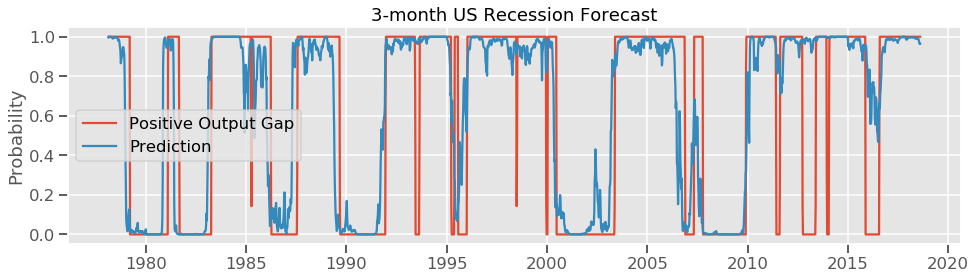

In [1563]:
pred = pd.DataFrame(clf.predict_proba(X_pca[:, :n_pc])[:, 1])
pred.set_index(X.index, inplace=True)
pred.columns = ["pred"]
fig = plt.figure(figsize=(16,4))
ax = plt.plot(pd.merge(df_merged.positive_gap[X_scaled.index], pred, on="date"))
plt.title("3-month US Recession Forecast")
plt.ylabel("Probability")
plt.legend(["Positive Output Gap", "Prediction"])
plt.savefig("../images/3m_gap_svc")
plt.show()

In [1834]:
clf = RandomForestClassifier(max_features=120, 
                             n_estimators=60, 
                             max_depth=8, 
                             min_samples_leaf=100, 
                             random_state=0,
                             class_weight="balanced"
                            )
clf.fit(X_train, y3m_train)
print(confusion_matrix(clf.predict(X_test), y3m_test))
print("train:", clf.score(X_train, y3m_train))
print("test", clf.score(X_test, y3m_test))

[[168 100]
 [ 60 322]]
train: 0.8356435643564356
test 0.7538461538461538


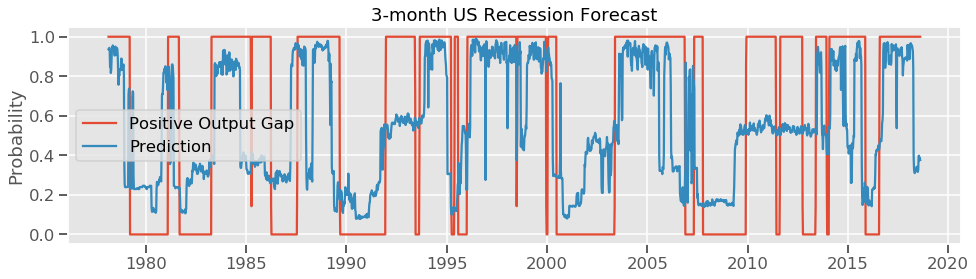

In [1835]:
pred = pd.DataFrame(clf.predict_proba(X_pca[:, :n_pc])[:, 1])
pred.set_index(X.index, inplace=True)
pred.columns = ["pred"]
fig = plt.figure(figsize=(16,4))
ax = plt.plot(pd.merge(df_merged.positive_gap[X_scaled.index], pred, on="date"))
plt.title("3-month US Recession Forecast")
plt.ylabel("Probability")
plt.legend(["Positive Output Gap", "Prediction"])
plt.savefig("../images/3m_gap_rfc")
plt.show()

In [1564]:
y6m_train = y6m[:int(X_pca.shape[0]*0.7)]
y6m_test = y6m[int(X_pca.shape[0]*0.7):]

In [1565]:
clf = SVC(C=35,
          gamma=0.00001,
          probability=True)
clf.fit(X_train, y6m_train)
print(confusion_matrix(clf.predict(X_test), y6m_test))
print(clf.score(X_train, y6m_train))
print(clf.score(X_test, y6m_test))

[[ 81   4]
 [160 405]]
0.9465346534653465
0.7476923076923077


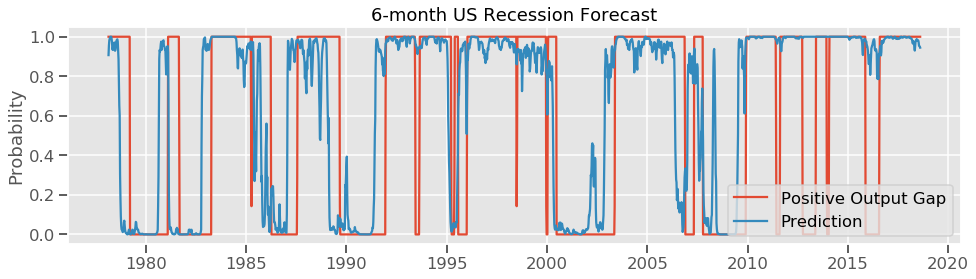

In [1566]:
pred = pd.DataFrame(clf.predict_proba(X_pca[:, :n_pc])[:, 1])
pred.set_index(X.index, inplace=True)
pred.columns = ["pred"]
fig = plt.figure(figsize=(16,4))
ax = plt.plot(pd.merge(df_merged.positive_gap[X_scaled.index], pred, on="date"))
plt.title("6-month US Recession Forecast")
plt.ylabel("Probability")
plt.legend(["Positive Output Gap", "Prediction"], loc=4)
plt.savefig("../images/6m_gap_svc")
plt.show()

In [1774]:
clf = RandomForestClassifier(max_features=100, 
                             n_estimators=30, 
                             max_depth=8, 
                             min_samples_leaf=100, 
                             random_state=0,
                             class_weight="balanced"
                            )
clf.fit(X_train, y6m_train)
print(confusion_matrix(clf.predict(X_test), y6m_test))
print(clf.score(X_train, y6m_train))
print(clf.score(X_test, y6m_test))

[[154  37]
 [ 87 372]]
0.8217821782178217
0.8092307692307692


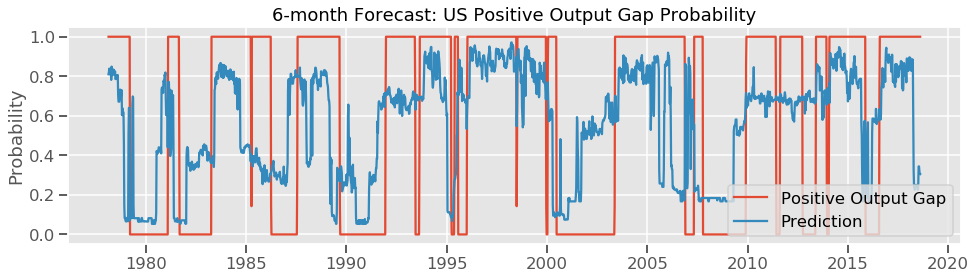

In [1775]:
pred = pd.DataFrame(clf.predict_proba(X_pca[:, :n_pc])[:, 1])
pred.set_index(X.index, inplace=True)
pred.columns = ["pred"]
fig = plt.figure(figsize=(16,4))
ax = plt.plot(pd.merge(df_merged.positive_gap[X_scaled.index], pred, on="date"))
plt.title("6-month Forecast: US Positive Output Gap Probability")
plt.ylabel("Probability")
plt.legend(["Positive Output Gap", "Prediction"], loc=4)
plt.savefig("../images/6m_gap_rfc")
plt.show()

[[103  60]
 [144 343]]
0.9478547854785478
0.76


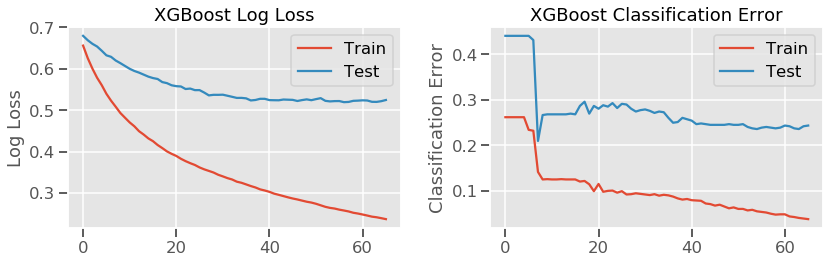

In [1794]:
clf = XGBClassifier(max_depth=2, 
                    learning_rate=0.1, 
                    n_estimators=200,
                    gamma=1,
                    random_state=0,
                    scale_pos_weight=y6m_train.value_counts()[0]/y6m_train.value_counts()[1]
                   )
clf.fit(X_train, 
        y6m_train, 
        eval_set = [(X_train, y6m_train), (X_test, y6m_test)],
        eval_metric=["error", "logloss"],
        early_stopping_rounds=10,
        verbose=False
       )
print(confusion_matrix(clf.predict(X_test), y12m_test))
print(clf.score(X_train, y6m_train))
print(clf.score(X_test, y6m_test))

# retrieve performance metrics
results = clf.evals_result()
epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)
# plot log loss
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,4))
ax[0].plot(x_axis, results['validation_0']['logloss'], label='Train')
ax[0].plot(x_axis, results['validation_1']['logloss'], label='Test')
ax[0].legend()
ax[0].set_ylabel('Log Loss')
ax[0].set_title('XGBoost Log Loss')
# plot classification error
ax[1].plot(x_axis, results['validation_0']['error'], label='Train')
ax[1].plot(x_axis, results['validation_1']['error'], label='Test')
ax[1].legend()
ax[1].set_ylabel('Classification Error')
ax[1].set_title('XGBoost Classification Error')
plt.tight_layout()
plt.show()

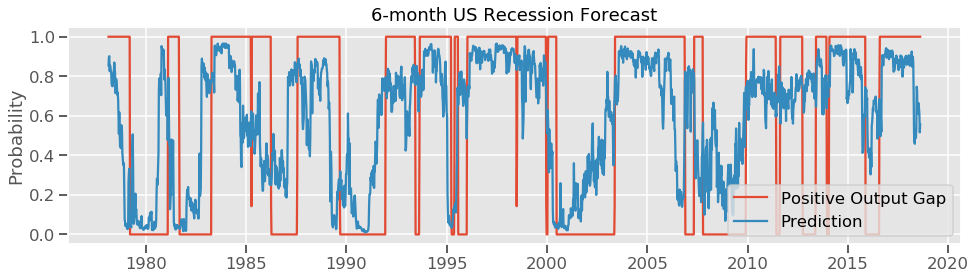

In [1795]:
pred = pd.DataFrame(clf.predict_proba(X_pca[:, :n_pc])[:, 1])
pred.set_index(X.index, inplace=True)
pred.columns = ["pred"]
fig = plt.figure(figsize=(16,4))
ax = plt.plot(pd.merge(df_merged.positive_gap[X_scaled.index], pred, on="date"))
plt.title("6-month US Recession Forecast")
plt.ylabel("Probability")
plt.legend(["Positive Output Gap", "Prediction"], loc=4)
plt.savefig("../images/6m_gap_xgc")
plt.show()

In [1571]:
y12m_train = y12m[:int(X_pca.shape[0]*0.7)]
y12m_test = y12m[int(X_pca.shape[0]*0.7):]

In [1800]:
clf = SVC(C=100, 
          gamma=0.000005, 
          probability=True,
          random_state=0,
          class_weight="balanced"
         )
clf.fit(X_train, y12m_train)
print(confusion_matrix(clf.predict(X_test), y12m_test))
print("train:", clf.score(X_train, y12m_train))
print("test:", clf.score(X_test, y12m_test))

[[ 54  25]
 [193 378]]
train: 0.9214521452145215
test: 0.6646153846153846


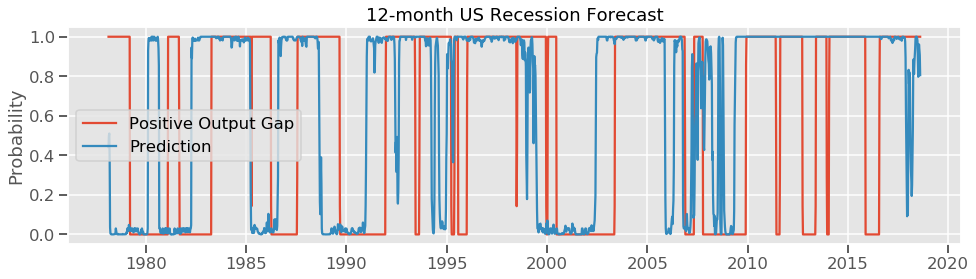

In [1797]:
pred = pd.DataFrame(clf.predict_proba(X_pca[:, :n_pc])[:, 1])
pred.set_index(X.index, inplace=True)
pred.columns = ["pred"]
fig = plt.figure(figsize=(16,4))
ax = plt.plot(pd.merge(df_merged.positive_gap[X_scaled.index], pred, on="date"))
plt.title("12-month US Recession Forecast")
plt.ylabel("Probability")
plt.legend(["Positive Output Gap", "Prediction"])
plt.savefig("../images/12m_gap_svc")
plt.show()

In [1738]:
y12m_train.value_counts()[1]/y12m_train.value_counts()[0]

1.4594155844155845

In [1761]:
clf = RandomForestClassifier(max_features=100, 
                             n_estimators=70, 
                             max_depth=30, 
                             min_samples_leaf=50,
                             random_state=0, 
                             class_weight="balanced"
                            )
clf.fit(X_train, 
        y12m_train)
print(confusion_matrix(clf.predict(X_test), y12m_test))
print("train:", clf.score(X_train, y12m_train))
print("test:", clf.score(X_test, y12m_test))

[[147  41]
 [100 362]]
train: 0.8844884488448845
test: 0.7830769230769231


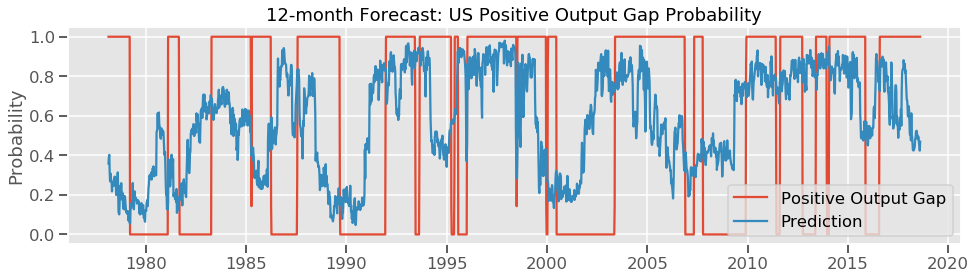

In [1762]:
pred = pd.DataFrame(clf.predict_proba(X_pca[:, :n_pc])[:, 1])
pred.set_index(X.index, inplace=True)
pred.columns = ["pred"]
fig = plt.figure(figsize=(16,4))
ax = plt.plot(pd.merge(df_merged.positive_gap[X_scaled.index], pred, on="date"))
plt.title("12-month Forecast: US Positive Output Gap Probability")
plt.ylabel("Probability")
plt.legend(["Positive Output Gap", "Prediction"], loc=4)
plt.savefig("../images/12m_gap_rfc")
plt.show()

[[ 79   0]
 [168 403]]
train: 0.7729372937293729
test: 0.7415384615384616


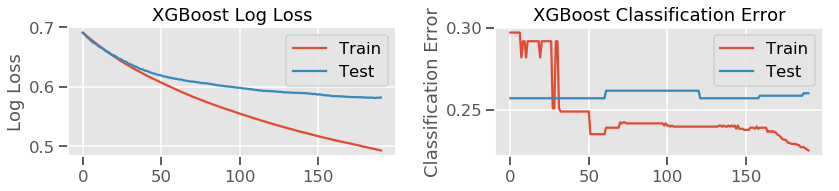

In [1807]:
clf = XGBClassifier(max_depth=2, 
                    learning_rate=0.01, 
                    n_estimators=200,
                    gamma=1,
                    scale_pos_weight=y6m_train.value_counts()[0]/y6m_train.value_counts()[1]
                   )
clf.fit(X_train, 
        y12m_train, 
        eval_set = [(X_train, y12m_train), (X_test, y12m_test)],
        eval_metric=["error", "logloss"],
        early_stopping_rounds=5,
        verbose=False
       )
print(confusion_matrix(clf.predict(X_test), y12m_test))
print("train:", clf.score(X_train, y12m_train))
print("test:", clf.score(X_test, y12m_test))

# retrieve performance metrics
results = clf.evals_result()
epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)
# plot log loss
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,3))
ax[0].plot(x_axis, results['validation_0']['logloss'], label='Train')
ax[0].plot(x_axis, results['validation_1']['logloss'], label='Test')
ax[0].legend()
ax[0].set_ylabel('Log Loss')
ax[0].set_title('XGBoost Log Loss')
# plot classification error
ax[1].plot(x_axis, results['validation_0']['error'], label='Train')
ax[1].plot(x_axis, results['validation_1']['error'], label='Test')
ax[1].legend()
ax[1].set_ylabel('Classification Error')
ax[1].set_title('XGBoost Classification Error')
plt.tight_layout()
plt.show()

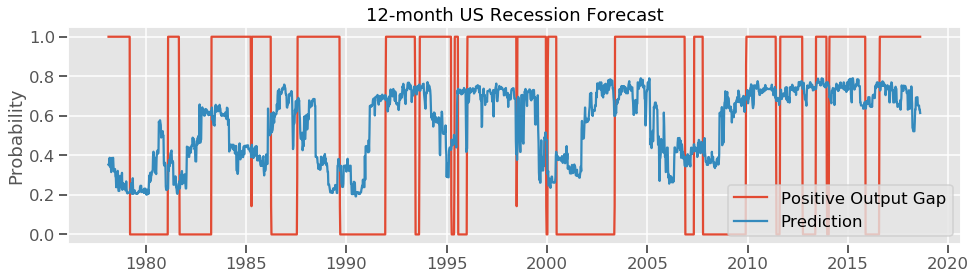

In [1808]:
pred = pd.DataFrame(clf.predict_proba(X_pca[:, :n_pc])[:, 1])
pred.set_index(X.index, inplace=True)
pred.columns = ["pred"]
fig = plt.figure(figsize=(16,4))
ax = plt.plot(pd.merge(df_merged.positive_gap[X_scaled.index], pred, on="date"))
plt.title("12-month US Recession Forecast")
plt.ylabel("Probability")
plt.legend(["Positive Output Gap", "Prediction"], loc=4)
plt.savefig("../images/12m_gap_xgc")
plt.show()

In [1836]:
actual = ["DGS30",
          "DGS10",
          "DGS2",
          "DGS5",
          "DTB3",
          "MORTGAGE30US",
          "AAA",
          "BAA",
          "FEDFUNDS",
          "TB3SMFFM",
          "UMCSENT",  
          "CIVPART",
          "TCU",
          "UNRATE",
          "LNS14000002",
          "NFCI",
          "2-10",
          "10-30",
#           "gap",
          "TERMCBAUTO48NS",
          "TERMCBPER24NS",
          "CEFDFSA066MSFRBPHI",
          "INTDSRUSM193N",
          "PSAVERT",
          "DPRIME",
          "MSACSR",
          "CSCICP03USM665S"
         ]

In [1837]:
week = change(df_merged, percent, actual, 1)
week_week = week.diff(1).add_suffix("_1")
month = change(df_merged, percent, actual, 4)
month_month = month.diff(4).add_suffix("_4")
three_m = change(df_merged, percent, actual, 13)
three_three = three_m.diff(13).add_suffix("_13")
six_m = change(df_merged, percent, actual, 26)
six_six = six_m.diff(26).add_suffix("_26")
one_y = change(df_merged, percent, actual, 52)

In [1838]:
X = pd.concat([week, 
               week_week, 
               month, 
               month_month, 
               three_m, 
               three_three, 
               six_m, 
               six_six, 
               one_y,
               df_merged[actual].fillna(method="ffill"),
               df_merged[actual].fillna(method="ffill").shift(1),
               df_merged[actual].fillna(method="ffill").shift(4),
               df_merged[actual].fillna(method="ffill").shift(13),
               df_merged[actual].fillna(method="ffill").shift(26),
               df_merged[actual].fillna(method="ffill").shift(52),
               df_WILL5000_5d_vol,
               df_WILL5000_30d_vol
              ], axis=1)[52:]

In [1839]:
X_gap = pd.concat([df_merged.gap,
#                    pd.DataFrame(df_merged.gap.diff(1)).add_suffix("_diff"),
#                    pd.DataFrame(df_merged.gap.diff(1).diff(1)).add_suffix("_diff_diff")
                  ], axis=1)[52:]

In [1840]:
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X))

In [1841]:
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

In [1843]:
X_pca_gap = np.concatenate([np.array(X_gap), X_pca], axis=1)

In [1844]:
X_pca_gap.shape

(2165, 780)

In [1845]:
n_pc = 150

In [1846]:
X_train_gap = X_pca_gap[:int(X_pca.shape[0]*0.7), :n_pc]
X_test_gap = X_pca_gap[int(X_pca.shape[0]*0.7):, :n_pc]

In [1847]:
X_train.shape

(1515, 150)

In [1848]:
g1w = df_merged.gap.shift(-1)[X.index].fillna(method="ffill")
g1m = df_merged.gap.shift(-4)[X.index].fillna(method="ffill")
g3m = df_merged.gap.shift(-13)[X.index].fillna(method="ffill")
g6m = df_merged.gap.shift(-26)[X.index].fillna(method="ffill")
g12m = df_merged.gap.shift(-52)[X.index].fillna(method="ffill")

In [1859]:
g6m_train = g6m[:int(X_pca.shape[0]*0.7)]
g6m_test = g6m[int(X_pca.shape[0]*0.7):]
g12m_train = g12m[:int(X_pca.shape[0]*0.7)]
g12m_test = g12m[int(X_pca.shape[0]*0.7):]

In [1850]:
# tscv = TimeSeriesSplit(n_splits=5)
# i = 1
# score_dict = {}
# for train_index, test_index in tscv.split(X_train):
#     X_tr, X_tst = X_train[train_index], X_train[test_index]
#     y_tr, y_tst = g12m_train[train_index], g12m_train[test_index]
#     score = 0
#     for c in [np.logspace(-10, 10, 2)]:
#         for e in [np.logspace(-20, 0, 2)]:
#             svm = SVR(C=c, epsilon=e, gamma="auto")
#             svm.fit(X_tr, y_tr)
#             if score < svm.score(X_tst, y_tst):
#                 score_dict[i] = [c, e, svm.score(X_tst, y_tst)]
#     i += 1

In [1860]:
svm = SVR(C=50, 
          epsilon=10**-7, 
          gamma="auto")
svm.fit(X_train_gap, g6m_train)
print("train", svm.score(X_train_gap, g6m_train))
print("test", svm.score(X_test_gap, g6m_test))

train 0.9998382210229748
test 0.11354151678923308


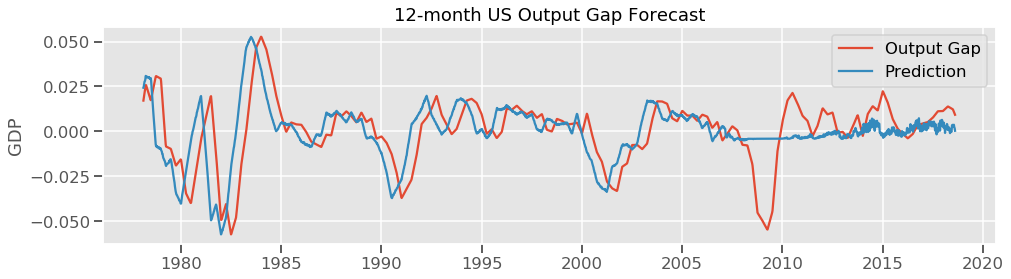

In [1861]:
pred = pd.DataFrame(svm.predict((X_pca_gap[:, :n_pc])))
pred.set_index(X.index, inplace=True)
pred.columns = ["pred"]
fig = plt.figure(figsize=(16,4))
ax = plt.plot(pd.merge(df_merged.gap[X_scaled.index], pred, on="date"))
plt.title("6-month US Output Gap Forecast")
plt.ylabel("GDP")
plt.legend(["Output Gap", "Prediction"])
plt.savefig("../images/6m_gap_svm")
plt.show()

In [1655]:
# tscv = TimeSeriesSplit(n_splits=5)
# i = 1
# score_dict = {}
# for train_index, test_index in tscv.split(X_train):
#     X_tr, X_tst = X_train[train_index], X_train[test_index]
#     y_tr, y_tst = g12m_train[train_index], g12m_train[test_index]
#     score = 0
#     for mf in np.linspace(10, 100, 10):
#         for ne in np.linspace(10, 30, 11):
#             for md in np.linspace(5, 25, 11):
#                 for msl in np.linspace(10, 40, 16):
#                     rfr = RandomForestRegressor(max_features=int(mf),
#                                                 n_estimators=int(ne), 
#                                                 max_depth=int(md),
#                                                 min_samples_leaf=int(msl)
#                                                )
#                     rfr.fit(X_tr, y_tr)
#                     if score < rfr.score(X_tst, y_tst):
#                         score_dict[i] = [mf, ne, md, msl, rfr.score(X_tst, y_tst)]
#     i += 1

In [1656]:
score_dict

{}

In [1967]:
rfr = RandomForestRegressor(max_features=50,
                            n_estimators=50, 
                            max_depth=20, 
                            min_samples_leaf=30,
                            random_state=0
                           )
rfr.fit(X_train_gap, g6m_train)
print("train: ", rfr.score(X_train_gap, g6m_train))
print("test: ", rfr.score(X_test_gap, g6m_test))

train:  0.8453945665491027
test:  0.5837646713624751


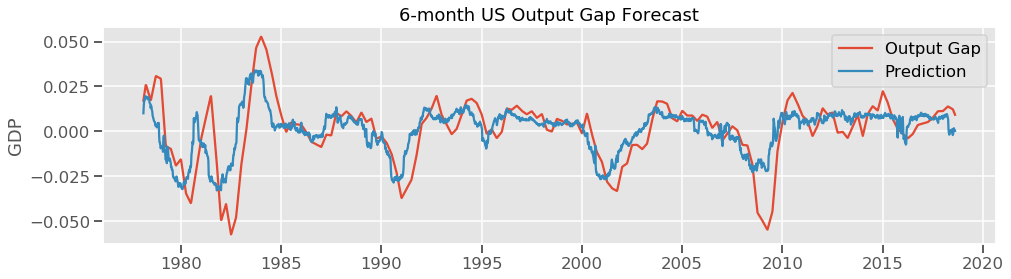

In [1968]:
pred = pd.DataFrame(rfr.predict((X_pca_gap[:, :n_pc])))
pred.set_index(X.index, inplace=True)
pred.columns = ["pred"]
fig = plt.figure(figsize=(16,4))
ax = plt.plot(pd.merge(df_merged.gap[X_scaled.index], pred, on="date"))
plt.title("6-month US Output Gap Forecast")
plt.ylabel("GDP")
plt.legend(["Output Gap", "Prediction"])
plt.savefig("../images/6m_gap_rfr")
plt.show()

In [1965]:
xgr = XGBRegressor(max_depth=3, 
                   min_child_weight=20,
                   gamma=0,
                   subsample=0.95,
                   colsample_bytree=1,
                   learning_rate=0.3, 
                   n_estimators=200,
                   reg_alpha=0.001,
                   random_state=0
                  )
xgr.fit(X_train_gap,
        g6m_train,
        eval_set=[(X_train_gap, g6m_train), (X_test_gap, g6m_test)],
        early_stopping_rounds=10,
        verbose=False)
print("train", xgr.score(X_train_gap, g6m_train))
print("test", xgr.score(X_test_gap, g6m_test))

/Users/kmiyaki/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/kmiyaki/anaconda3/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[14:13:02] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
train 0.9418930335640976
test 0.6216088657039738


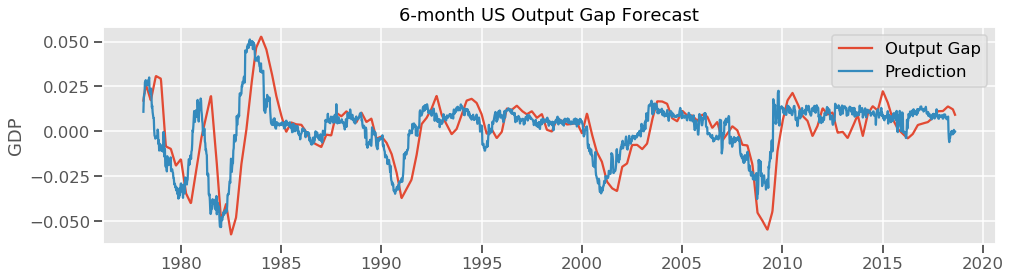

In [1966]:
pred = pd.DataFrame(xgr.predict((X_pca_gap[:, :n_pc])))
pred.set_index(X.index, inplace=True)
pred.columns = ["pred"]
fig = plt.figure(figsize=(16,4))
ax = plt.plot(pd.merge(df_merged.gap[X_scaled.index], pred, on="date"))
plt.title("6-month US Output Gap Forecast")
plt.ylabel("GDP")
plt.legend(["Output Gap", "Prediction"])
plt.savefig("../images/6m_gap_xgr")
plt.show()

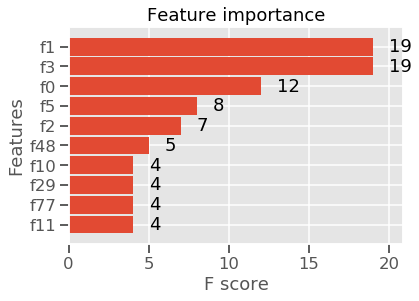

In [1969]:
plot_importance(xgr, height=0.9, max_num_features=10)
plt.show()

In [1852]:
svm = SVR(C=50, 
          epsilon=10**-7, 
          gamma="auto")
svm.fit(X_train_gap, g12m_train)
print("train", svm.score(X_train_gap, g12m_train))
print("test", svm.score(X_test_gap, g12m_test))

train 0.9998294373229254
test 0.07605416797646702


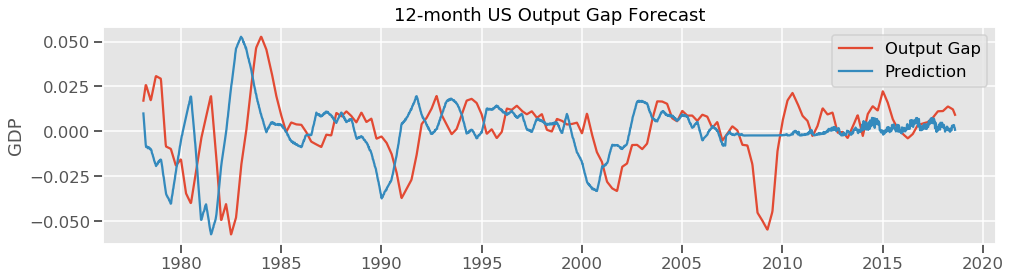

In [1853]:
pred = pd.DataFrame(svm.predict((X_pca_gap[:, :n_pc])))
pred.set_index(X.index, inplace=True)
pred.columns = ["pred"]
fig = plt.figure(figsize=(16,4))
ax = plt.plot(pd.merge(df_merged.gap[X_scaled.index], pred, on="date"))
plt.title("12-month US Output Gap Forecast")
plt.ylabel("GDP")
plt.legend(["Output Gap", "Prediction"])
plt.savefig("../images/12m_gap_svm")
plt.show()

In [1655]:
# tscv = TimeSeriesSplit(n_splits=5)
# i = 1
# score_dict = {}
# for train_index, test_index in tscv.split(X_train):
#     X_tr, X_tst = X_train[train_index], X_train[test_index]
#     y_tr, y_tst = g12m_train[train_index], g12m_train[test_index]
#     score = 0
#     for mf in np.linspace(10, 100, 10):
#         for ne in np.linspace(10, 30, 11):
#             for md in np.linspace(5, 25, 11):
#                 for msl in np.linspace(10, 40, 16):
#                     rfr = RandomForestRegressor(max_features=int(mf),
#                                                 n_estimators=int(ne), 
#                                                 max_depth=int(md),
#                                                 min_samples_leaf=int(msl)
#                                                )
#                     rfr.fit(X_tr, y_tr)
#                     if score < rfr.score(X_tst, y_tst):
#                         score_dict[i] = [mf, ne, md, msl, rfr.score(X_tst, y_tst)]
#     i += 1

In [1656]:
score_dict

{}

In [1854]:
rfr = RandomForestRegressor(max_features=50,
                            n_estimators=50, 
                            max_depth=20, 
                            min_samples_leaf=30,
                            random_state=0
                           )
rfr.fit(X_train_gap, g12m_train)
print("train: ", rfr.score(X_train_gap, g12m_train))
print("test: ", rfr.score(X_test_gap, g12m_test))

train:  0.7578666537088659
test:  0.21983755820515793


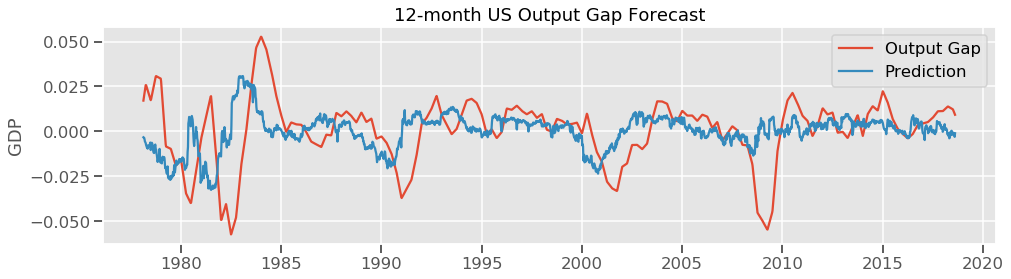

In [1855]:
pred = pd.DataFrame(rfr.predict((X_pca_gap[:, :n_pc])))
pred.set_index(X.index, inplace=True)
pred.columns = ["pred"]
fig = plt.figure(figsize=(16,4))
ax = plt.plot(pd.merge(df_merged.gap[X_scaled.index], pred, on="date"))
plt.title("12-month US Output Gap Forecast")
plt.ylabel("GDP")
plt.legend(["Output Gap", "Prediction"])
plt.savefig("../images/12m_gap_rfr")
plt.show()

In [1856]:
xgr = XGBRegressor(max_depth=2, 
                   learning_rate=0.13, 
                   n_estimators=40)
xgr.fit(X_train_gap,
        g12m_train)
print("train", xgr.score(X_train_gap, g12m_train))
print("test", xgr.score(X_test_gap, g12m_test))

/Users/kmiyaki/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/kmiyaki/anaconda3/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[13:21:01] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
train 0.7542366339768557
test 0.07902309812474029


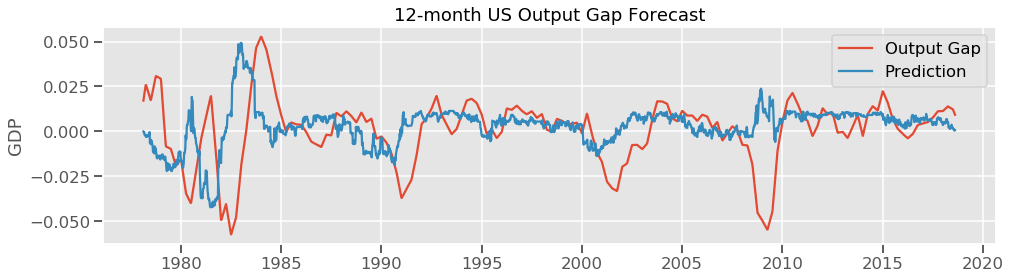

In [1857]:
pred = pd.DataFrame(xgr.predict((X_pca_gap[:, :n_pc])))
pred.set_index(X.index, inplace=True)
pred.columns = ["pred"]
fig = plt.figure(figsize=(16,4))
ax = plt.plot(pd.merge(df_merged.gap[X_scaled.index], pred, on="date"))
plt.title("12-month US Output Gap Forecast")
plt.ylabel("GDP")
plt.legend(["Output Gap", "Prediction"])
plt.savefig("../images/12m_gap_xgr")
plt.show()